# Section 1: Business Understanding

AirBnb dataset is really interesting and I think we can try to understand how the data is changing throughout the year.

Specific business questions:
1. How does the average price change across the year?
2. Whats the hardest time to get a reservation?
3. How do the consumers choose to rate their property, is there specific reasons for getting a high score?
4. How do price and score affect each other?

# Section 2: Data Understanding

In [9]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import seaborn as sns
from datetime import datetime

In [10]:
'''
This section loads the 3 DF's and takes only 2016 data
'''

df_calendar = pd.read_csv('raw_data/calendar.csv')
df_listings = pd.read_csv('raw_data/listings.csv')
df_reviews = pd.read_csv('raw_data/reviews.csv')

# want to use 2016 data
df_calendar = df_calendar[df_calendar['date']<'2017-01-01']
df_reviews = df_reviews[df_reviews['date']<'2017-01-01']

In [11]:
# check we dont have 2017 data
df_calendar[df_calendar['date']>='2017-01']

,listing_id,date,available,price


Great! its clean for 2017, we can anlyze 2016

In [14]:
# print the head to see the raw data
df_calendar[0:3]

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN


Looks like we have 5 columns, month of listing, id, price (its a string, will have to clean), and if its available.
Lets see what values are inside "available".

In [15]:
df_calendar['available'].unique()

array(['t', 'f'], dtype=object)

Cool its only true or false.

In [21]:
df_calendar['price'].isna().mean()

0.3298064698607582

In [26]:
print('Perentage of priced listing: {}%'.format(1-df_calendar['price'].isna().mean()))

Perentage of priced listing: 0.6701935301392419%


OK so we only have 67% of the values price, because the rest are rented.

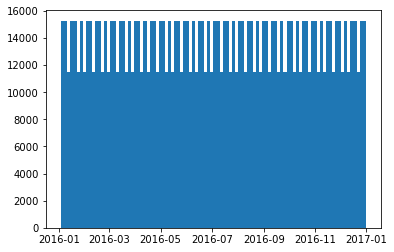

In [296]:
# Lets see the data across the year, looks like evenly distabuted!
plt.hist(pd.to_datetime(df_calendar['date']), bins=100)
plt.show()

# Section 3: Data Preparation

In the last section I saw that the price is string with $ so lets clean it!

In [31]:
# Creating only priced listing df
priced_df_calendar = df_calendar[~df_calendar['price'].isna()]
priced_df_calendar['price'] = priced_df_calendar['price'].str.replace('$','',regex=False).str.replace(',','',regex=False).astype('float')

<ipython-input-31-9323f187790a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  priced_df_calendar['price'] = priced_df_calendar['price'].str.replace('$','',regex=False).str.replace(',','',regex=False).astype('float')


### The reason I decided to use only data points with price is because I want to analyze the average price for free rooms, not for ones that are full and have no price.

In [32]:
type(priced_df_calendar['price'].sum())
# its a float, looks good!

numpy.float64

In [33]:
# removing $ sign from price so we can calculate mean/max/etc prices later
df_listings['price'] = df_listings['price'].str.replace('$','').str.replace(',','').astype('float')

<ipython-input-33-1f10ee5e1785>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_listings['price'] = df_listings['price'].str.replace('$','').str.replace(',','').astype('float')


In [34]:
type(df_listings['price'].sum())
# its a float, looks good!

numpy.float64

I want to create a month column for the graphs.

In [36]:
# Change date type and create month filed
df_reviews['date'] = pd.to_datetime(df_reviews['date'])
df_reviews['month'] = df_reviews['date'].dt.to_period('M')

In [38]:
df_reviews[0:1]

,listing_id,id,date,reviewer_id,reviewer_name,comments,month
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,2015-07


Looks good!

In [39]:
# Change date type and create month filed
df_calendar['date'] = pd.to_datetime(df_calendar['date'])
df_calendar['month'] = df_calendar['date'].dt.to_period('M')

# create a priced df, cleaning the $ sign
priced_df_calendar = df_calendar[~df_calendar['price'].isna()]
priced_df_calendar['price'] = priced_df_calendar['price'].str.replace('$','',regex=False).str.replace(',','',regex=False).astype('float')

<ipython-input-39-d575b5222abe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  priced_df_calendar['price'] = priced_df_calendar['price'].str.replace('$','',regex=False).str.replace(',','',regex=False).astype('float')


Lets see if the string column is now a float

In [45]:
type(priced_df_calendar[priced_df_calendar['month']=='2016-01']['price'].sum())

numpy.float64

Looks good!

In [264]:
# Create a list of scoring colums for later analysis
score_column = ['review_scores_rating','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location']

In [323]:
df_listings[score_column][0:1]
# looks good!

,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location
0,95.0,10.0,10.0,10.0,9.0


In [46]:
# merge the two dataframes, we will use it in a later stage to compare diffrent features that are in both data frames
merged_calendar_listings = pd.merge(right=priced_df_calendar,left=df_listings, right_on='listing_id',left_on='id',how='right')

In [47]:
df_monthed = merged_calendar_listings.groupby(by=['month'], as_index=False).mean()[['month','review_scores_rating','price_y']]

In [48]:
df_monthed

,month,review_scores_rating,price_y
0,2016-01,94.290268,121.568409
1,2016-02,94.377616,124.293927
2,2016-03,94.487285,128.644488
3,2016-04,94.478512,135.097005
4,2016-05,94.481624,139.538183
5,2016-06,94.417122,147.473137
6,2016-07,94.300753,152.094150
7,2016-08,94.362683,150.656594
8,2016-09,94.376173,143.255949
9,2016-10,94.392681,137.031939


Looks good, we have a new df

# Section 4: Evaluate the Results

Let's use the score_column list in the prep section to see the correlation between the different features.

First ill create a function for that.

In [306]:
def corr_metrix(df,colum_names):
    '''
    This function will take a data frame, list of feature name and print its correlation matrix.
    
    Input:
    Df (Pandas.Dataframe) - data frame that hold the colmus that will be checked for corralation
    Colum_names (list) - list of colum names that will be printed
    
    Output:
    Correlation matrix (AxesSubplot(0.125,0.125;0.62x0.755) - a printed correlation 
    matrix
    '''
    
    
    score_corr = df[colum_names].corr()
    
    print(sns.heatmap(score_corr, annot=True))
    print('Correlation between different categories ranking')

### How do the consumers choose to rate their property, is there specific reasons for getting a high score?


AxesSubplot(0.125,0.125;0.62x0.755)
Correlation between different categories ranking


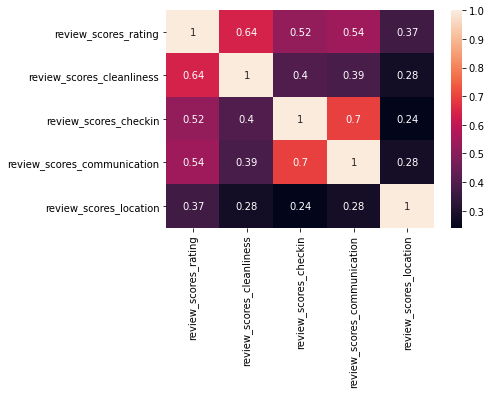

In [307]:
corr_metrix(df_listings,score_column)

AirBnB gives its users a few categories to rank there stay, when looking at the correlation between the different categories to the overall score we get an interesting insight:

The most correlative categories is cleanliness, afterwards comes communications, checkin and last is location. That’s surprising! I would imagine location would be at top, a good explanation could be that location is known in advance while the other metrics are only discovered during the vacation.

### How does the average price change across the year?

<AxesSubplot:xlabel='month', ylabel='price_y'>

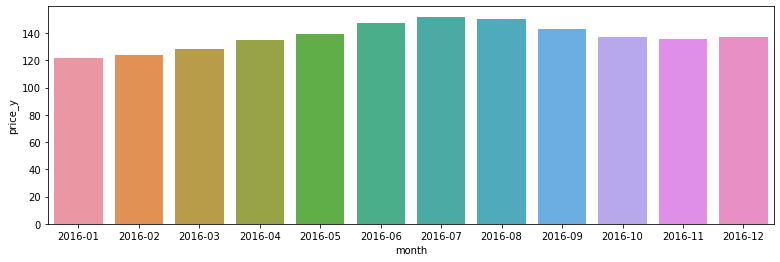

In [57]:
# lets see if the score changes over the year, doesnt look like!
plt.figure(figsize=(13, 4))
sns.barplot(data=df_monthed,x='month', y='price_y')

#print('Average price month')

It is not too surprising to see that summer time is the most expensive time to visit, the average price picks to 140$, while the cheapest time is winter.

### How do price and score affect each other?

Price and score scatter plot


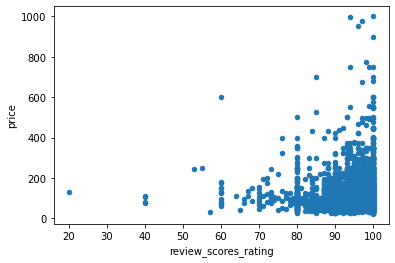

In [286]:
# Lets print the score vs price hist!
df_listings[['price','review_scores_rating']].plot(kind='scatter', x='review_scores_rating',y='price')
print('Price and score scatter plot')

In the graph below, each data point represents a listing, the most expensive properties have high scores, but the majority of the 80–100 scores are priced below 400$. That can be explained by the fact that people’s score is mostly, “value for money”, meaning they will rank a property high even if it’s not the most luxurious, as long as they get what they expect.

### Whats the hardest time to get a reservation?

In [50]:
# Lets take a look at a stacked bar graph to see when rooms are free! 
# Creating pivot table to get us the data in the right order for the graph

df_piv = df_calendar.groupby(by=['available','month'], as_index=False).count().pivot(columns='available',values='listing_id',index='month').reset_index()
df_piv.columns = ['month','Fully_booked','Have_rooms']

Amount of free units


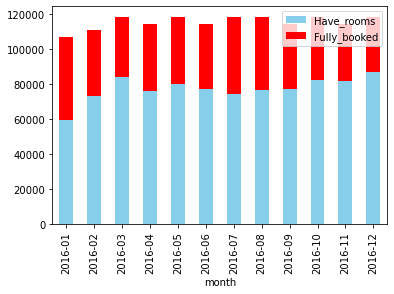

In [51]:
df_piv.plot(kind='bar', stacked=True, color=['skyblue','red'],x='month',y=['Have_rooms','Fully_booked'])
print('Amount of free units')

Amount of un-rented units
Fully booked rooms:


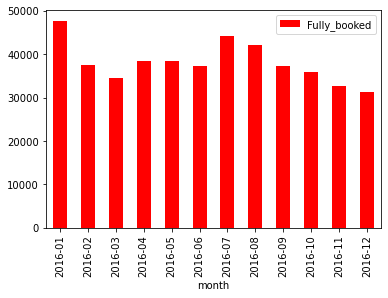

In [52]:
# Lets take a look at the fully booked data
print('Amount of un-rented units')
df_piv.plot(kind='bar', stacked=True, color=['red'],x='month',y=['Fully_booked'])
print('Fully booked rooms:')

Amount of un-rented units
Booked rooms:


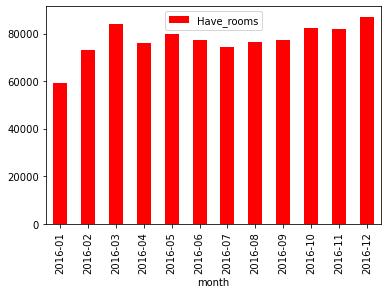

In [53]:
print('Amount of un-rented units')
df_piv.plot(kind='bar', stacked=True, color=['red'],x='month',y=['Have_rooms'])
print('Booked rooms:')

January is in fact the time of year with the least amount of free rooms for rent. That is caused partly because some residences don’t offer rooms at that time (lowest bar) of the year, but surprisingly it’s also because January appears to be the time of year with the highest number of rooms booked, maybe because of the lower price range.